<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/PyStan/CoinTossProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pickle
file=open('/content/CoinToss/coin_toss','rb')
data=pickle.load(file)
file.close()
samples=data['samples']
alpha0=data['prior']['alpha']
beta0=data['prior']['beta']
n=samples.size

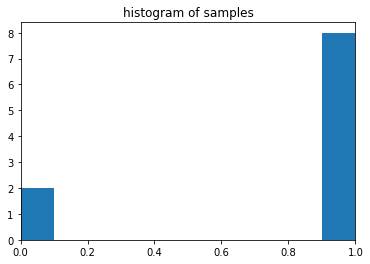

In [5]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

In [6]:
stan_bernoulli = """
data {
  int<lower=0> n;
  int<lower=0, upper=1> heads[n];
  real alpha0;
  real beta0;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  heads ~ bernoulli(theta);
  theta ~ beta(alpha0, beta0);
}
"""

#**Using HMC(Hamiltonian Monte Carlo)**

In [7]:
model_bernoulli = pystan.StanModel(model_code=stan_bernoulli)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18bdecd784a575468a8abc566d68f410 NOW.


In [8]:
coin_data = {
    'n':     n,
    'heads': samples,
    'alpha0':     alpha0,
    'beta0':     beta0
}

In [9]:
model_bernoulli_hmc = model_bernoulli.sampling(data=coin_data, chains=8, warmup=500, iter=1500)

In [10]:
model_bernoulli_hmc

Inference for Stan model: anon_model_18bdecd784a575468a8abc566d68f410.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.51  1.5e-3   0.09   0.35   0.45   0.51   0.57   0.68   3089    1.0
lp__  -24.78    0.01   0.75 -26.88 -24.95 -24.48  -24.3 -24.25   3538    1.0

Samples were drawn using NUTS at Mon Jun 13 08:17:08 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [11]:
theta_hmc=(model_bernoulli_hmc.extract())['theta'].mean()
theta_hmc

0.5124297992749289

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1870aae50>,
      dtype=object)

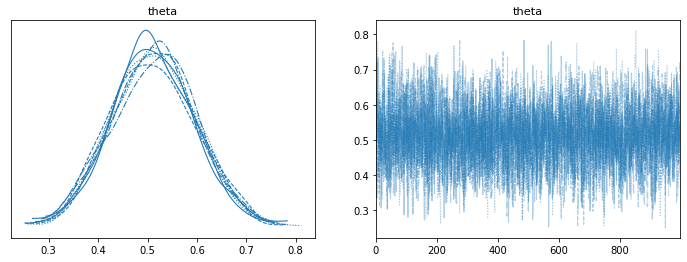

In [12]:
az.plot_trace(model_bernoulli_hmc, figsize = (12, 4))

In [13]:
bernoullihmc_df = model_bernoulli_hmc.to_dataframe()
bernoullihmc_df

,chain,draw,warmup,theta,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.421821,-24.850954,0.851473,1.027999,1,3,0,25.034556
1,0,1,0,0.338502,-26.523288,0.887895,1.027999,2,3,0,26.523508
2,0,2,0,0.352787,-26.150396,1.000000,1.027999,1,1,0,26.815687
3,0,3,0,0.517785,-24.246722,0.993284,1.027999,1,3,0,26.159183
4,0,4,0,0.591042,-24.666061,0.901407,1.027999,1,3,0,24.748299
...,...,...,...,...,...,...,...,...,...,...,...
7995,7,995,0,0.645289,-25.504715,0.888360,0.774002,1,1,0,25.517952
7996,7,996,0,0.604822,-24.833898,1.000000,0.774002,1,1,0,25.385775
7997,7,997,0,0.574278,-24.501017,1.000000,0.774002,1,1,0,24.771200
7998,7,998,0,0.722640,-27.648664,0.692593,0.774002,2,3,0,28.277014


# **Using Variational Inference(VI)**

In [14]:
model_bernoulli_vi=model_bernoulli.vb(data=coin_data,seed=123)

In [15]:
model_bernoulli_vi

OrderedDict([('args',
              {'adapt_engaged': True,
               'adapt_iter': 50,
               'algorithm': 'MEANFIELD',
               'append_samples': False,
               'chain_id': 1,
               'elbo_samples': 100,
               'enable_random_init': False,
               'eta': 1.0,
               'eval_elbo': 100,
               'grad_samples': 1,
               'init': b'random',
               'init_radius': 2.0,
               'iter': 10000,
               'method': 'VARIATIONAL',
               'output_samples': 1000,
               'random_seed': '123',
               'sample_file': b'/tmp/tmpb51h53q8/output.csv',
               'tol_rel_obj': 0.01}),
             ('inits', [0.6624060062395454]),
             ('sampler_params',
              [[0.4661686100965069,
                0.49178345806666235,
                0.5491422781564529,
                0.43213049822938265,
                0.6419664756008088,
                0.6165230399708646,
           

In [16]:
theta_vi=model_bernoulli_vi.get('mean_pars')
theta_vi

[0.49541918960716136]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe183a02d50>,
      dtype=object)

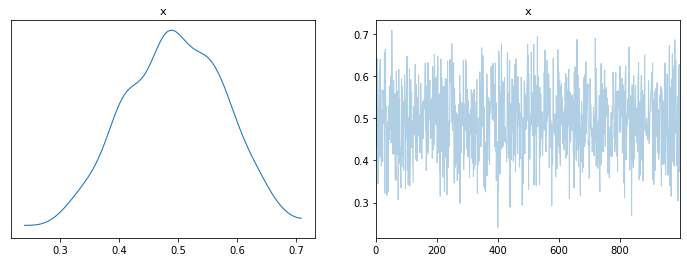

In [17]:
az.plot_trace(data=np.array(model_bernoulli_vi.get('sampler_params')[0]), figsize = (12, 4))

In [18]:
theta_vi=np.array(model_bernoulli_vi.get('sampler_params')[0])

#**Plotting the distributions**


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


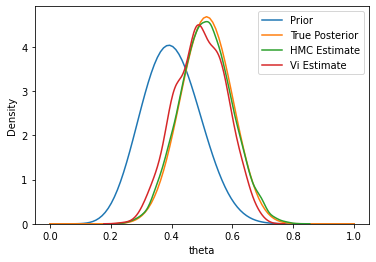

In [19]:
beta_dist = tfd.Beta(alpha0,beta0)
x = jnp.linspace(0,1,100)
beta_pdf = beta_dist.prob(x)
plt.plot(x,beta_pdf,label="Prior")

one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')
beta_dist = tfd.Beta(alpha0+one,beta0+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")

theta_hmc = bernoullihmc_df['theta']
sns.kdeplot(theta_hmc,label="HMC Estimate")
sns.kdeplot(theta_vi,label="Vi Estimate")
plt.legend()
plt.show()

In [21]:
with open("/content/CoinToss_Data/Results",'wb') as f:
    pickle.dump(theta_hmc, f,protocol = 1)